# Ingreduce : Data Visualization and Analysis

Hooray! 50,000 recipes on our web app have been viewed since its launch a couple of months ago, and we now want to analyze that data. 

Actually, no. It was all a dream, and we haven't launched that web app yet. Since that data doesn't actually exist, I first need to create some mock data. 

## Creating the mock data

I'll create a dataset called `recipe_viewed` that tracks user interactions with the recipes that they have viewed. In this dataset, each record is a view of a recipe by an user, and it will have five pieces of information associated with it:
- `recipe_id` is a unique identifier for each recipe. This is the recipe being viewed.
- `user_id`is a unique identifier for each user. This is the user that is viewing the recipe.
- `date` is the date of the view.
- `duration` is the duration time of the view.
- `is_liked` tells whether or not the recipe viewed has been liked (or unliked).

This is how I'll proceed to create the dataset. First, I'll create a list of recipe ids, user ids, etc, for each variable associated with the records (except for duration which will be generated through a function). Then, if appropriate, those lists will have items that have specific distributions. Finally, the records will be created by randomly choosing the values from each list.

In [1]:
import pickle
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt

### Creating a list of recipe ids
All recipes in our database have a unique identifier, which is their index number. Those numbers range from 0 to 4839. They will be our recipe ids.

```Python
num_recipes = 4840 # we have 4840 recipes in our database
recipe_ids = [i for i in range(num_recipes)]
```

### Creating a list of user ids

Let's suppose that we currently have 839 registered users. Each user is assigned a unique identifier ranging from 0 to 838.

```Python
# Creating a list of user ids.
num_users = 839
user_ids = [i for i in range(num_users)]
```

### Creating a list of dates

First, I need to set some random data about the views. Let's say that:
- We have launched our web app on the 2/16/2022.
- Since then, 50,000 recipes have been viewed.
- There has been two peaks of visits: one because of our launch campaign and the other one is due to more free time during summertime.
- There are two daily peaks: one around 1PM and another, bigger one around 7PM.

```Python
# Adapted from but largely inspired by Michelle Ho
# https://gist.github.com/michellemho/82f1b0300bcc2d3702db154908524151#file-datetime_fake-py

num_recipes_viewed = 50000
launch_date=datetime(2022,2,16)
end_date=datetime.today()
summer_peak = datetime(2022,8,5)
campaign_peak = datetime(2022,4,15)

def hour_prob(h):
    # Peaks around 1 PM and 7 PM
    hour_prob = np.exp(-(h - 13)**2/(2*4)) + 1.3*np.exp(-(h - 19)**2/(2*4)) + 0.05
    return hour_prob

def daily_prob(d, start_date=launch_date, end_date=end_date, summer_peak=summer_peak, campaign_peak=campaign_peak):
    date = launch_date + timedelta(days=d)
    date_range_domain = (end_date - launch_date).days

    days_to_summer_peak = summer_peak.timetuple().tm_yday - launch_date.timetuple().tm_yday
    days_to_campaign_peak = campaign_peak.timetuple().tm_yday - launch_date.timetuple().tm_yday
    
    eq_components = {}

    for peak in [days_to_summer_peak, days_to_campaign_peak]:
        counter = peak
        year = 0
        while counter < date_range_domain:
            equation = np.exp(-(d - (365*year + peak))**2/(2*5000))
            eq_components[counter+peak] = equation
            counter += 365
            year += 1
    return sum(eq_components.values(),0.05)
      
def calc_cpd(prob, domain):
    norm_prob = [prob(a) for a in range(domain)] / np.sum([prob(a) for a in range(domain)])
    cpd = np.cumsum(norm_prob)
    return cpd

def sample_cpd(cpd, n_samples):
    samples = np.random.uniform(size=n_samples)
    return np.digitize(samples,cpd)
  
n_samples = num_recipes_viewed
hours = sample_cpd(calc_cpd(hour_prob,24), n_samples)
days = sample_cpd(calc_cpd(daily_prob,(end_date - launch_date).days), n_samples)
list_dates = [launch_date + timedelta(hours = int(h)) + timedelta(days = int(d)) for h, d in list(zip(hours, days))]
```

### Creating a function for duration times

First, let's say that:
- We automatically log users out after 24 hours.
- Users typically
    - view a recipe for around 1 minute when they are uninterested by it, 
    - view it for around 6-10 minutes when they are just reading the entire recipe, 
    - and usually stay on the recipe when they are following it for until as long as it takes to make the recipe (unless they are logged out before). 

And the proportions for the view to fall into one of the three situations are 70, 20 and 10, respectively.

So, in order to get user's view times when they are following the recipe, we need to have all recipes' total cooking times data. Currently, each recipe's total cooking time in our database is in the format of a string. Since that I am interested with cooking times in the scale of minutes, let's start by writing a function that can convert the strings into the corresponding time in minutes.

Note that, since users are automatically logged out after 24 hours, we don't need to compute the recipe's total cooking time if it is over 24 hours. Instead, they will be assigned a value of 1440, which is the number of minutes in 24 hours.
Another quirk about our recipe dataset is the presence of recipes with no total cooking time available. They will be assigned a value of 1, which is the same as if users would be uninterested by it.

```Python
def format_duration(total_time):
    '''Returns a recipe's total cooking time in minutes. 
    If the recipe's total cooking time is over 24 hours, then it returns 1440.
    If the recipe has no total cooking time, then it returns 1.'''
    
    if total_time == None:
        duration = 1
    
    elif 'week' in total_time or 'day' in total_time:
        duration = 1440
    
    elif 'hr' in total_time:
        
        hrs = int(total_time.split('hr')[0])
        
        splitted = total_time.split()
        
        for index, element in enumerate(splitted):
            if 'min' in element:
                min_index = index - 1
                minutes = int(splitted[min_index])
            else:
                minutes = 0
        
        duration = hrs * 60 + minutes
        
    else:
        splitted = total_time.split('min')
        duration = int(splitted[0])
        
    return duration
```

Next, let's make a copy of the recipe dataset which will contain the column of the total cooking time in minutes for each recipe.

```Python
# Importing our recipe dataset
filename = 'df_recipes'
infile = open(filename,'rb')
df_recipes = pickle.load(infile)
df_recipes.set_index('index', inplace=True)

# Creating a dataset with total times in minutes
df_times = df_recipes.copy()

df_times['total_minutes'] = df_times.apply(lambda row: format_duration(row['total']), axis=1)
```
Now we can define the function that will randomly choose between the three user behaviors within their respective probabilities, as mentioned above.

```Python
def returns_duration(recipe_id):

    cooking_time = df_times.loc[recipe_id, 'total_minutes']

    duration_times = [1, 6, 7, 8, 9, 10, cooking_time]
    
    prob = random.choices(duration_times, weights=(70,4,4,4,4,4,10), k=100)
    
    return random.choice(prob)
```

### Creating a list for `is_liked` column

Here we define a list with one of the two user behaviors:
- either the user has 'liked' the recipe (or hasn't removed their like), therefore the recipe is 'liked' (`True`).
- or the user has not 'liked' the recipe (or has 'unliked' it), therefore the recipe is not 'liked' (`False`).

Probabilities for this data point won't be set for now.

```Python
is_liked = [True, False]
```

### Creating the dataset
Now let's create the DataFrame where those views will be logged.

```Python
df = pd.DataFrame({
    'recipe_id': random.choice(recipe_ids),
    'user_id': random.choice(user_ids),
    'date': random.choice(list_dates),
    'is_liked': random.choice(is_liked)
} for i in range(num_recipes_viewed))
```

Lastly, let's create the last column of our mock dataset, `duration`, which depends on the recipe id of each record.

```Python
df['duration'] = df.apply(lambda row: returns_duration(row['recipe_id']), axis=1)

# Saving our mock dataset
filename = 'recipe_viewed'
outfile = open(filename,'wb')
pickle.dump(df,outfile)
outfile.close()
```
Now, we're all set for the analysis!

## Analysis and Visualization

First, we need to import the previously created `recipe_viewed` dataset.

In [2]:
filename = 'recipe_viewed'
infile = open(filename,'rb')
recipe_viewed = pickle.load(infile)

In [3]:
df = recipe_viewed.copy()
df

,recipe_id,user_id,date,is_liked,duration
0,186,557,2022-05-09 20:00:00,False,430
1,3549,93,2022-05-10 19:00:00,True,8
2,2872,32,2022-03-10 15:00:00,False,35
3,3505,629,2022-06-17 12:00:00,True,1
4,1842,128,2022-06-13 21:00:00,True,15
...,...,...,...,...,...
49995,2581,499,2022-02-16 15:00:00,True,1
49996,720,249,2022-05-11 12:00:00,False,1
49997,1280,308,2022-06-17 16:00:00,True,1
49998,4208,641,2022-04-17 17:00:00,False,1


As a start, we can have a look at the number of recipes viewed overtime.

In [38]:
# Frequency table of date
ft_date = df['date'].value_counts(bins=20)
ft_date

(2022-03-27 00:30:00, 2022-04-03 19:36:00]              3077
(2022-04-19 09:48:00, 2022-04-27 04:54:00]              3063
(2022-04-27 04:54:00, 2022-05-05]                       3013
(2022-04-03 19:36:00, 2022-04-11 14:42:00]              2985
(2022-05-05, 2022-05-12 19:06:00]                       2969
(2022-04-11 14:42:00, 2022-04-19 09:48:00]              2961
(2022-03-19 05:24:00, 2022-03-27 00:30:00]              2935
(2022-05-12 19:06:00, 2022-05-20 14:12:00]              2747
(2022-03-11 10:18:00, 2022-03-19 05:24:00]              2727
(2022-03-03 15:12:00, 2022-03-11 10:18:00]              2612
(2022-05-20 14:12:00, 2022-05-28 09:18:00]              2592
(2022-05-28 09:18:00, 2022-06-05 04:24:00]              2508
(2022-02-23 20:06:00, 2022-03-03 15:12:00]              2436
(2022-02-15 21:15:28.799999999, 2022-02-23 20:06:00]    2356
(2022-06-05 04:24:00, 2022-06-12 23:30:00]              2342
(2022-06-12 23:30:00, 2022-06-20 18:36:00]              2088
(2022-06-20 18:36:00, 20

Here we can see the number of views for each of the 20 time periods. Each period corresponds approximatively to a week's time. There has been noticeably less and less views over time. Is it because our users don't like our recipes? Let's explore this possibility.

### Do our users like our recipes?

#### How many recipes do our users like?

First, let's find the number of recipes liked over time. To do so, first, we need to find the number of recipes each day. Then, we can plot it.

In [4]:
def all_likes_todate(df, date):
    '''Returns a list of tuples of recipes still liked on a given day and the user who liked it. '''
    
    likes_list = []
    
    filt = (df['date'] < date)
    df = df.loc[filt]
    
    for idx,row in df.iterrows():
        user = df.loc[idx, 'user_id']
        recipe = df.loc[idx, 'recipe_id']
        like_tuple = (user, recipe)
        
        if df.loc[idx, 'is_liked'] == True:
            likes_list.append(like_tuple)
        
        if df.loc[idx, 'is_liked'] == False:
            if like_tuple in likes_list:
                likes_list.remove(like_tuple)            
    
    return likes_list

In [17]:
all_likes = all_likes_todate(df_chron, datetime(2022,7,22))

In [5]:
def recipes_liked_todate(date, df):
    '''Returns the list of recipes still liked on a given day.'''
    
    num_recipes_liked = []
    
    likes_list = all_likes_todate(df, date)

    for like_tuple in likes_list:
        recipe = like_tuple[1]
        if recipe not in num_recipes_liked:
            num_recipes_liked.append(recipe)
            
    return num_recipes_liked

In [8]:
def num_liked_todate(date, df):
    '''Returns the number of recipes still liked on a given day. '''
    likes_list = all_likes_todate(df, date)
    num_recipes_liked = recipes_liked_todate(date, df, likes_list)
    return len(num_recipes_liked)

We need to have the dataset in chronological order for the functions to work. So, let's do this!

In [7]:
df_chron = df.copy().sort_values('date', ascending = True).reset_index()
df_chron

,index,recipe_id,user_id,date,is_liked,duration
0,5253,2600,18,2022-02-16 01:00:00,False,232
1,8778,4075,101,2022-02-16 01:00:00,False,10
2,33986,1706,669,2022-02-16 02:00:00,False,1
3,18572,3371,432,2022-02-16 02:00:00,False,1
4,30855,1711,337,2022-02-16 02:00:00,False,8
...,...,...,...,...,...,...
49995,40576,4179,252,2022-07-21 22:00:00,False,1
49996,20113,3900,700,2022-07-21 22:00:00,True,1
49997,21208,2869,746,2022-07-21 22:00:00,True,1
49998,5112,3284,162,2022-07-21 22:00:00,False,1


Now we can generate the two lists of values for the graph.

In [10]:
liked_overtime = []
dates = []

# Getting a list of dates between the launch and 'end' dates

launch_date=datetime(2022,2,16)
end_date=datetime(2022,7,21)

def daterange(start, end):
    for n in range(int ((end - start).days)+1):
        yield start + timedelta(n)
    
# Generating the lists

for dt in daterange(launch_date, end_date):
    nbr_liked = num_liked_todate(dt, df_chron)
    liked_overtime.append(nbr_liked)
    dates.append(dt)

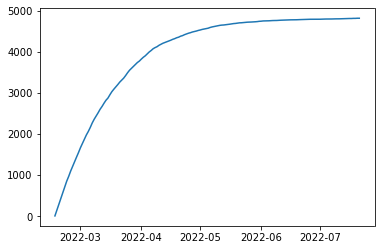

In [11]:
x = dates
y = liked_overtime
plt.plot(x, y)
plt.show()

In [13]:
liked_overtime[-1]

4813

To this date, 4813 recipes have been liked by at least one user over the 4840 recipes available on our web app. We may assume that the recipe selection for our web app was good, or at least, good enough so that almost all have been liked by our users.

But are they equally popular with all users? Let's find out.

#### Are all recipes equally liked?

In [25]:
def most_liked_recipes(likes_list):
    
    likes_per_recipe = {}
    
    for like_tuple in likes_list:
        recipe = like_tuple[1]
        likes_per_recipe[recipe] = likes_per_recipe.get(recipe, 0) + 1
    
    most_liked_df = pd.DataFrame.from_dict(likes_per_recipe, orient='index', columns=['num_likes'])
    
    return most_liked_df.sort_values(by='num_likes', ascending=False)

most_liked_recipes(all_likes).value_counts()

num_likes
5            845
4            833
6            708
3            624
7            519
2            400
8            353
9            202
1            143
10           117
11            38
13            15
12            14
15             2
dtype: int64

Now we can see that, although a lot of recipes on our web app were liked, most recipes have in between 4 and 6 likes. And each recipe has at most 15 likes.

#### Does a recipe's visibility play a role in whether or not it is 'liked'?

Are the most liked recipes the most viewed and vice-versa? If so, simple 'exposure' (or lack thereof) could explain the contrast of the popularity of recipes.

In [26]:
def num_viewed_recipes(df, date):
    
    viewed_recipes = []
    
    filt = (df['date'] < date)
    df = df.loc[filt]
    
    for idx,row in df.iterrows():
        user = df.loc[idx, 'user_id']
        recipe = df.loc[idx, 'recipe_id']
        view_tuple = (user, recipe)
        viewed_recipes.append(view_tuple)
    
    return len(set(viewed_recipes))

In [28]:
viewed_overtime = []

for dt in daterange(launch_date, end_date):
    nbr_viewed = num_viewed_recipes(df_chron, dt)
    viewed_overtime.append(nbr_viewed)

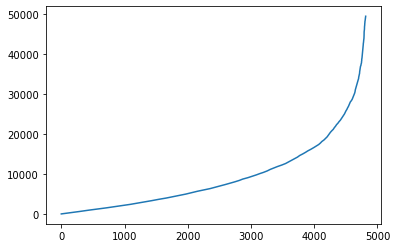

In [29]:
x = liked_overtime
y = viewed_overtime
plt.plot(x, y)
plt.show()

In [30]:
# Frequency table of recipe_id
ft_recipe = df['recipe_id'].value_counts()
ft_recipe

1374    23
2596    23
107     23
2902    23
78      22
        ..
3258     2
362      2
1962     2
3288     1
2047     1
Name: recipe_id, Length: 4840, dtype: int64

This is the number of views per recipes.

In [34]:
print('Recipes have been viewed at most by', ft_recipe.max(), 'users.')
print('Recipes have been viewed by least', ft_recipe.min(), 'user.')
print('Recipes have been viewed by', ft_recipe.mean(), 'users, on average.')

Recipes have been viewed at most by 23 users.
Recipes have been viewed by least 1 user.
Recipes have been viewed by 10.330578512396695 users, on average.


Since recipes have been viewed at most by 23 users, this explains why there are so few likes on the recipes. The view-likes graph above shows that a recipe's visibility does increase its 'like' likelihood.

#### How many recipes have each user viewed?

In [35]:
# Frequency table of user_id
ft_user = df['user_id'].value_counts()
ft_user

438    85
405    84
266    83
742    83
71     81
       ..
520    40
641    38
696    37
174    36
330    35
Name: user_id, Length: 839, dtype: int64

Here we can see the number of views per user. Note that they may have viewed the same recipe(s) multiple times.

In [37]:
print('Users have viewed at most', ft_user.max(), 'recipes.')
print('Users have viewed at least', ft_user.min(), 'recipes.')
print('Users have viewed', ft_user.mean(), 'recipes on average.')

Users have viewed at most 85 recipes.
Users have viewed at least 35 recipes.
Users have viewed 59.594755661501786 recipes on average.


Now, a less alarming picture is painted. Let's summarize all we've learned so far. Views are dropping but all recipes have been liked by at least one user. While each recipe has a low like percentage when taking into account the number of users that we have on the web app, this seems to be explained by the number of recipes that the users have been. In fact, it seems like the more views, the more likely a recipe may be liked.

As a conclusion, there are less views either because users have found satisfaction with the recipes that they have liked, or there is another (bad) reason which I haven't found yet...